In [1]:
import sys
from pathlib import Path 
sys.path.append(str(Path.cwd().parent.parent))
import numpy as np
from kymatio.scattering2d.core.scattering2d import scattering2d
import matplotlib.pyplot as plt
import torch
from kymatio import Scattering2D

In [2]:
def create_filter(theta,slant,xi,sigma):
    n_filters = 1
    device = None

    orientations = np.array([[np.cos(theta),np.sin(theta)]]) 
    slants = np.array([slant])
    xis = np.array([xi])
    sigmas = np.array([sigma])

    xis = torch.tensor(xis, dtype=torch.float32, device=device)
    sigmas = torch.tensor(sigmas, dtype=torch.float32, device=device)
    slants = torch.tensor(slants, dtype=torch.float32, device=device)
    orientations = torch.tensor(orientations, dtype=torch.float32, device=device)  

    shape = (32, 32,)
    ranges = [torch.arange(-(s // 2), -(s // 2) + s, device=device, dtype=torch.float) for s in shape]
    grid = torch.stack(torch.meshgrid(*ranges), 0)
    wavelet = morlets(grid, orientations, xis, sigmas, slants, device=device)
    
    return wavelet

In [3]:
def construct_scattering(input, scattering, psi):
    if not torch.is_tensor(input):
        raise TypeError('The input should be a PyTorch Tensor.')

    if len(input.shape) < 2:
        raise RuntimeError('Input tensor must have at least two dimensions.')

    if not input.is_contiguous():
        raise RuntimeError('Tensor must be contiguous.')

    if (input.shape[-1] != scattering.N or input.shape[-2] != scattering.M) and not scattering.pre_pad:
        raise RuntimeError('Tensor must be of spatial size (%i,%i).' % (scattering.M, scattering.N))

    if (input.shape[-1] != scattering.N_padded or input.shape[-2] != scattering.N_padded) and scattering.pre_pad:
        raise RuntimeError('Padded tensor must be of spatial size (%i,%i).' % (scattering.M_padded, scattering.N_padded))

    if not scattering.out_type in ('array', 'list'):
        raise RuntimeError("The out_type must be one of 'array' or 'list'.")

    batch_shape = input.shape[:-2]
    signal_shape = input.shape[-2:]

    input = input.reshape((-1,) + signal_shape)


    S = scattering2d(input, scattering.pad, scattering.unpad, scattering.backend, scattering.J,
                        scattering.L, scattering.phi, psi, scattering.max_order, scattering.out_type)

    if scattering.out_type == 'array':
        scattering_shape = S.shape[-3:]
        S = S.reshape(batch_shape + scattering_shape)
    # else:
    #     scattering_shape = S[0]['coef'].shape[-2:]
    #     new_shape = batch_shape + scattering_shape

    #     for x in S:
    #         x['coef'] = x['coef'].reshape(new_shape)

    return S

def update_psi(J, psi, wavelets,  initialization , device):
    wavelets = wavelets.real.contiguous().unsqueeze(3)
    
    if J == 2:
        for i,d in enumerate(psi):
                d[0] = wavelets[i]

    else:
        count = 0
        for i,d in enumerate(psi):
            for res in range(0, J-1):
                try:
                    d[res]
                    if res == 0:
                        d[res] = wavelets[count]
                    else:
                        d[res] = periodize_filter_fft(wavelets[count].squeeze(2), res, device).unsqueeze(2)
                    count +=1
                except KeyError:
                    pass
                
    return psi

def get_total_num_filters(J, L):
    num_filters = 0
    for j in range(2,J+1):
        num_filters += j *L
    return num_filters  

def periodize_filter_fft_v1(x, res, device):
    """
        Parameters
        ----------
        x : numpy array
            signal to periodize in Fourier
        res :
            resolution to which the signal is cropped.
        Returns
        -------
        crop : torch array
            It returns a crop version of the filter, assuming that
             the convolutions will be done via compactly supported signals.
    """

    M = x.shape[0]
    N = x.shape[1]

    crop = torch.zeros((M // 2 ** res, N // 2 ** res), dtype = x.dtype).to(device)

    mask = torch.ones(x.shape, dtype =torch.float32).to(device)
    len_x = int(M * (1 - 2 ** (-res)))
    start_x = int(M * 2 ** (-res - 1))
    len_y = int(N * (1 - 2 ** (-res)))
    start_y = int(N * 2 ** (-res - 1))
    mask[start_x:start_x + len_x,:] = 0
    mask[:, start_y:start_y + len_y] = 0
    x = x*mask

    for k in range(int(M / 2 ** res)):
        for l in range(int(N / 2 ** res)):
            for i in range(int(2 ** res)):
                for j in range(int(2 ** res)):
                    crop[k, l] += x[k + i * int(M / 2 ** res), l + j * int(N / 2 ** res)]

    return crop

def periodize_filter_fft(x, res, device):
    """
        Parameters
        ----------
        x : numpy array
            signal to periodize in Fourier
        res :
            resolution to which the signal is cropped.

        Returns
        -------
        crop : torch array
            It returns a crop version of the filter, assuming that
             the convolutions will be done via compactly supported signals.
    """

    s1, s2 = x.shape
    periodized = x.reshape(res*2, s1// 2**res, res*2, s2//2**res).mean(dim=(0,2))
    return periodized 

def create_filters_params_random(n_filters, is_scattering_dif, device):
    """
    a 'random' initialization
    """
    #n_filters = J*L
    #sigmas = np.log(np.random.uniform(np.exp(0), np.exp(3), n_filters ))
    # For the orientation, choose uniform on the circle 
    #(can init some 2d gaussian values then divide by their norm 
    # or take complex exponential/ cos & sin of uniform between 0 and 2pi).
    orientations = np.random.normal(0,1,(n_filters,2)) 
    norm = np.linalg.norm(orientations, axis=1).reshape(orientations.shape[0], 1)
    orientations = orientations/norm
    slants = np.random.uniform(0.5, 1.5,n_filters )# like uniform between 0.5 and 1.5.
    xis = np.random.uniform(0.5, 1, n_filters )
    # sigmas = np.log(np.random.uniform(np.exp(1), np.exp(5), n_filters))
    sigmas = np.log(np.random.uniform(np.exp(1), np.exp(3), n_filters))
    
    xis = torch.tensor(xis, dtype=torch.float32, device=device)
    sigmas = torch.tensor(sigmas, dtype=torch.float32, device=device)
    slants = torch.tensor(slants, dtype=torch.float32, device=device)
    orientations = torch.tensor(orientations, dtype=torch.float32, device=device)  
    params = [orientations, xis, sigmas, slants]

    if is_scattering_dif:
        for param in params:
            param.requires_grad = True

    return  params

def create_filters_params(J, L, is_scattering_dif, device):
    '''
        Create reusable filters parameters: orientations, xis, sigmas, sigmas

        mimicking the kymatio initialization
    '''
    orientations = []
    xis = []
    sigmas = []
    slants = []

    for j in range(J):
        for theta in range(L):
            for res in range(min(j + 1, max(J - 1, 1))):
                sigma = 0.8 * 2**j
                sigmas.append(0.8 * 2**j)
                t = ((int(L-L/2-1)-theta) * np.pi / L)
                xis.append(3.0 / 4.0 * np.pi /2**j)
                slant = 4.0/L
                slants.append(slant)

                #orientations.append(np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]], np.float32))
                #R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]], np.float32)
                D = np.array([[1, 0], [0, slant * slant]])
                R_inv = np.array([[np.cos(t), np.sin(t)], [-np.sin(t), np.cos(t)]], np.float32)
                #orientations.append( (np.dot(R, np.dot(D, R_inv)) / ( 2 * sigma * sigma)))
                orientations.append(R_inv)    

            
    xis = torch.tensor(xis, dtype=torch.float32, device=device)
    sigmas = torch.tensor(sigmas, dtype=torch.float32, device=device)
    slants = torch.tensor(slants, dtype=torch.float32, device=device)
    orientations = torch.tensor(orientations, dtype=torch.float32, device=device)  

    params = [orientations[:, 0], xis, sigmas, slants]
    if is_scattering_dif:
        for param in params:
            param.requires_grad = True
    return  params


def raw_morlets(grid_or_shape, wave_vectors, gaussian_bases, morlet=True, ifftshift=True, fft=True):
    """Helper funciton for morlets

    --long description TODO pour laurent
    """
    n_filters, n_dim = wave_vectors.shape
    assert gaussian_bases.shape == (n_filters, n_dim, n_dim)
    device = wave_vectors.device

    if isinstance(grid_or_shape, tuple):
        shape = grid_or_shape
        ranges = [torch.arange(-(s // 2), -(s // 2) + s, device=device, dtype=torch.float) for s in shape]
        grid = torch.stack(torch.meshgrid(*ranges), 0)
    else:
        shape = grid_or_shape.shape[1:]
        grid = grid_or_shape

    waves = torch.exp(1.0j * torch.matmul(grid.T, wave_vectors.T).T)
    gaussian_directions = torch.matmul(grid.T, gaussian_bases.T.reshape(n_dim, n_dim * n_filters)).T
    gaussian_directions = gaussian_directions.reshape((n_dim, n_filters) + shape)
    radii = torch.norm(gaussian_directions, dim=0)
    gaussians = torch.exp(-0.5 * radii ** 2)
    signal_dims = list(range(1, n_dim + 1))
    gabors = gaussians * waves

    if morlet:
        gaussian_sums = gaussians.sum(dim=signal_dims, keepdim=True)
        gabor_sums = gabors.sum(dim=signal_dims, keepdim=True).real
        morlets = gabors - gabor_sums / gaussian_sums * gaussians
        filters = morlets
    else:
        filters = gabors
    if ifftshift:
        filters = torch.fft.ifftshift(filters, dim=signal_dims)
    if fft:
        filters = torch.fft.fftn(filters, dim=signal_dims)

    return filters

def morlets(grid_or_shape, orientations, xis, sigmas, slants, device=None, morlet=True, ifftshift=True, fft=True):
    """Creates morlet wavelet filters from input

    --long description TODO pour laurent
    """
    if device is None:
        device = orientations.device

    n_filters, ndim = orientations.shape
    orientations = orientations / (torch.norm(orientations, dim=1, keepdim=True) + 1e-19)
    wave_vectors = orientations * xis[:, np.newaxis]

    _, _, gauss_directions = torch.linalg.svd(orientations[:, np.newaxis])
    gauss_directions = gauss_directions / sigmas[:, np.newaxis, np.newaxis]
    indicator = torch.arange(ndim,device=device) < 1
    slant_modifications = (1.0 * indicator + slants[:, np.newaxis] * ~indicator)
    gauss_directions = gauss_directions * slant_modifications[:, :, np.newaxis]

    wavelets = raw_morlets(grid_or_shape, wave_vectors, gauss_directions, morlet=morlet, 
                          ifftshift=ifftshift, fft=fft)

    norm_factors = (2 * 3.1415 * sigmas * sigmas / slants).unsqueeze(1)

    if type(grid_or_shape) == tuple:
        norm_factors = norm_factors.expand([n_filters,grid_or_shape[0]]).unsqueeze(2).repeat(1,1,grid_or_shape[1])
    else:
        norm_factors = norm_factors.expand([n_filters,grid_or_shape.shape[1]]).unsqueeze(2).repeat(1,1,grid_or_shape.shape[2])

    wavelets = wavelets / norm_factors

    return wavelets

In [4]:
def visualizeFiltersDynamic(offset):
    f, axarr = plt.subplots(4,3,figsize=(6, 8))
    f.suptitle('Morlet wavelet parameters variation effect')
    names = ['Theta','Slant','Xi','Sigma']
    modes = ['fourier','real', 'imag']
    j=1
    #offset = np.linspace(-0.75,0.75,100)
    offset = offset
    theta = np.pi/2
    slant = 0.5
    xi = 3.0 / 4.0 * np.pi /2**j
    sigma = 0.8 * 2**j
    for i,name in enumerate(names):
        if i==0:
            wavelet = create_filter(theta+offset,slant,xi,sigma) # à vectoriser
        elif i==1:
            wavelet = create_filter(theta,slant+offset,xi,sigma)
        elif i==2:
            wavelet = create_filter(theta,slant,xi+offset,sigma)
        elif i==3:
            wavelet = create_filter(theta,slant,xi,sigma+offset)
            
        for j,mode in enumerate(modes):
            if mode == 'fourier':
                x =np.fft.fftshift(wavelet.squeeze().cpu().detach().numpy()).real
                if i==0:
                    axarr[i,j].set_title(f"Frequencies")
            elif mode == 'real':
                x= np.fft.fftshift(np.fft.ifft2(wavelet.squeeze().cpu().detach().numpy())).real
                if i==0:
                    axarr[i,j].set_title(f"Real part")
            elif mode == 'imag':
                x= np.fft.fftshift(np.fft.ifft2(wavelet.squeeze().cpu().detach().numpy())).imag
                if i==0:
                    axarr[i,j].set_title(f"Imaginary part")
            else:
                raise NotImplemented(f"Model {params['name']} not implemented")

            a=np.abs(x).max()
            axarr[i,j].imshow(x, vmin=-a, vmax=a)
            axarr[i,j].set_xticklabels([])
            axarr[i,j].set_yticklabels([])
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            axarr[i,j].set_aspect('equal')

    for idx,ax in enumerate(axarr[:,0].flat):
        ax.set(ylabel=names[idx])

    f.tight_layout()

In [15]:
def visualizeFiltersDynamicAll(offset=0.0,
                               theta=np.pi/2,
                               slant=0.5,
                               xi= (3.0 / 4.0 * np.pi /2**(1)),
                               sigma=(0.8 * 2**(1))
                               ):
    f, axarr = plt.subplots(4,3,figsize=(6, 8))
    f.suptitle('Morlet wavelet parameters variation effect')
    names = ['Theta','Slant','Xi','Sigma']
    modes = ['fourier','real', 'imag']
    j=1
    #offset = np.linspace(-0.75,0.75,100)
    #     offset = offset
    #     theta = np.pi/2
    #     slant = 0.5
    #     xi = 3.0 / 4.0 * np.pi /2**j
    #     sigma = 0.8 * 2**j
    for i,name in enumerate(names):
        if i==0:
            wavelet = create_filter(theta+offset,slant,xi,sigma) # à vectoriser
        elif i==1:
            wavelet = create_filter(theta,slant+offset,xi,sigma)
        elif i==2:
            wavelet = create_filter(theta,slant,xi+offset,sigma)
        elif i==3:
            wavelet = create_filter(theta,slant,xi,sigma+offset)
            
        for j,mode in enumerate(modes):
            if mode == 'fourier':
                x =np.fft.fftshift(wavelet.squeeze().cpu().detach().numpy()).real
                if i==0:
                    axarr[i,j].set_title(f"Frequencies")
            elif mode == 'real':
                x= np.fft.fftshift(np.fft.ifft2(wavelet.squeeze().cpu().detach().numpy())).real
                if i==0:
                    axarr[i,j].set_title(f"Real part")
            elif mode == 'imag':
                x= np.fft.fftshift(np.fft.ifft2(wavelet.squeeze().cpu().detach().numpy())).imag
                if i==0:
                    axarr[i,j].set_title(f"Imaginary part")
            else:
                raise NotImplemented(f"Model {params['name']} not implemented")

            a=np.abs(x).max()
            axarr[i,j].imshow(x, vmin=-a, vmax=a)
            axarr[i,j].set_xticklabels([])
            axarr[i,j].set_yticklabels([])
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            axarr[i,j].set_aspect('equal')

    for idx,ax in enumerate(axarr[:,0].flat):
        ax.set(ylabel=names[idx])

    f.tight_layout()

In [16]:
def visualizeFiltersRef(offset,filename="",save=False):
    f, axarr = plt.subplots(5,3,figsize=(5, 8))
    f.suptitle('Morlet wavelet parameters variation effect')
    names = ['Ref','Theta offset','Slant offset','Xi offset','Sigma offset']
    modes = ['fourier','real', 'imag']
    j=1
    offset = offset
    theta = np.pi/2
    slant = 0.5
    xi = 3.0 / 4.0 * np.pi /2**j
    sigma = 0.8 * 2**j
    for i,name in enumerate(names):
        if i == 0:
            wavelet = create_filter(theta,slant,xi,sigma)
        elif i==1:
            wavelet = create_filter(theta+offset,slant,xi,sigma)
        elif i==2:
            wavelet = create_filter(theta,slant+offset,xi,sigma)
        elif i==3:
            wavelet = create_filter(theta,slant,xi+offset,sigma)
        elif i==4:
            wavelet = create_filter(theta,slant,xi,sigma+offset)
        for j,mode in enumerate(modes):
            if mode =='fourier':
                x =np.fft.fftshift(wavelet.squeeze().cpu().detach().numpy()).real
                if i==0:
                    axarr[i,j].set_title(f"Frequencies")
            elif mode == 'real':
                x= np.fft.fftshift(np.fft.ifft2(wavelet.squeeze().cpu().detach().numpy())).real
                if i==0:
                    axarr[i,j].set_title(f"Real part")
            elif mode == 'imag':
                x= np.fft.fftshift(np.fft.ifft2(wavelet.squeeze().cpu().detach().numpy())).imag
                if i==0:
                    axarr[i,j].set_title(f"Imaginary part")
            else:
                raise NotImplemented(f"Model {params['name']} not implemented")

            a=np.abs(x).max()
            axarr[i,j].imshow(x, vmin=-a, vmax=a)
            axarr[i,j].set_xticklabels([])
            axarr[i,j].set_yticklabels([])
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            axarr[i,j].set_aspect('equal')

    for idx,ax in enumerate(axarr[:,0].flat):
        ax.set(ylabel=names[idx])

    f.tight_layout()
    if save:
        if filename == '':
            print("no filename specified")
            raise Exception
            
        f.savefig(filename)

In [17]:
%matplotlib inline

from ipywidgets import interact
import ipywidgets as widgets
j=1
interact(visualizeFiltersDynamicAll,offset=0.0,
                               theta=np.pi/2,
                               slant=0.5,
                               xi= (3.0 / 4.0 * np.pi /2**j),
                               sigma=(0.8 * 2**j))

interactive(children=(FloatSlider(value=0.0, description='offset', max=1.0), FloatSlider(value=1.5707963267948…

<function __main__.visualizeFiltersDynamicAll(offset=0.0, theta=1.5707963267948966, slant=0.5, xi=1.1780972450961724, sigma=1.6)>

TODO : For each parameter, a slider

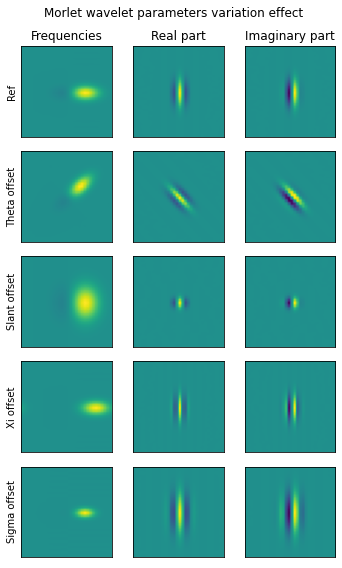

In [7]:
visualizeFiltersRef(offset=0.75,filename="",save=False)